In [2]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import PPCA_MR as p
import statsmodels.api as sm
import quandl
token="QWe8iSbyAFzRuod2aroM"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [4]:
cleansed=load_amihud_markets_price()

tsmom_model.py:158: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Dollar turnover

Looks terrible as the data quality is poor


$$  \sum {\text{dvol}_t} $$



In [5]:
dvol=calculate_dollar_volume(cleansed)

tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='mean')
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='sum')
tsmom_model.py:35: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='m',how='mean')[:'2016']
tsmom_model.py:35: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='m',how='mean')[:'2016']
tsmom_model.py:38: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

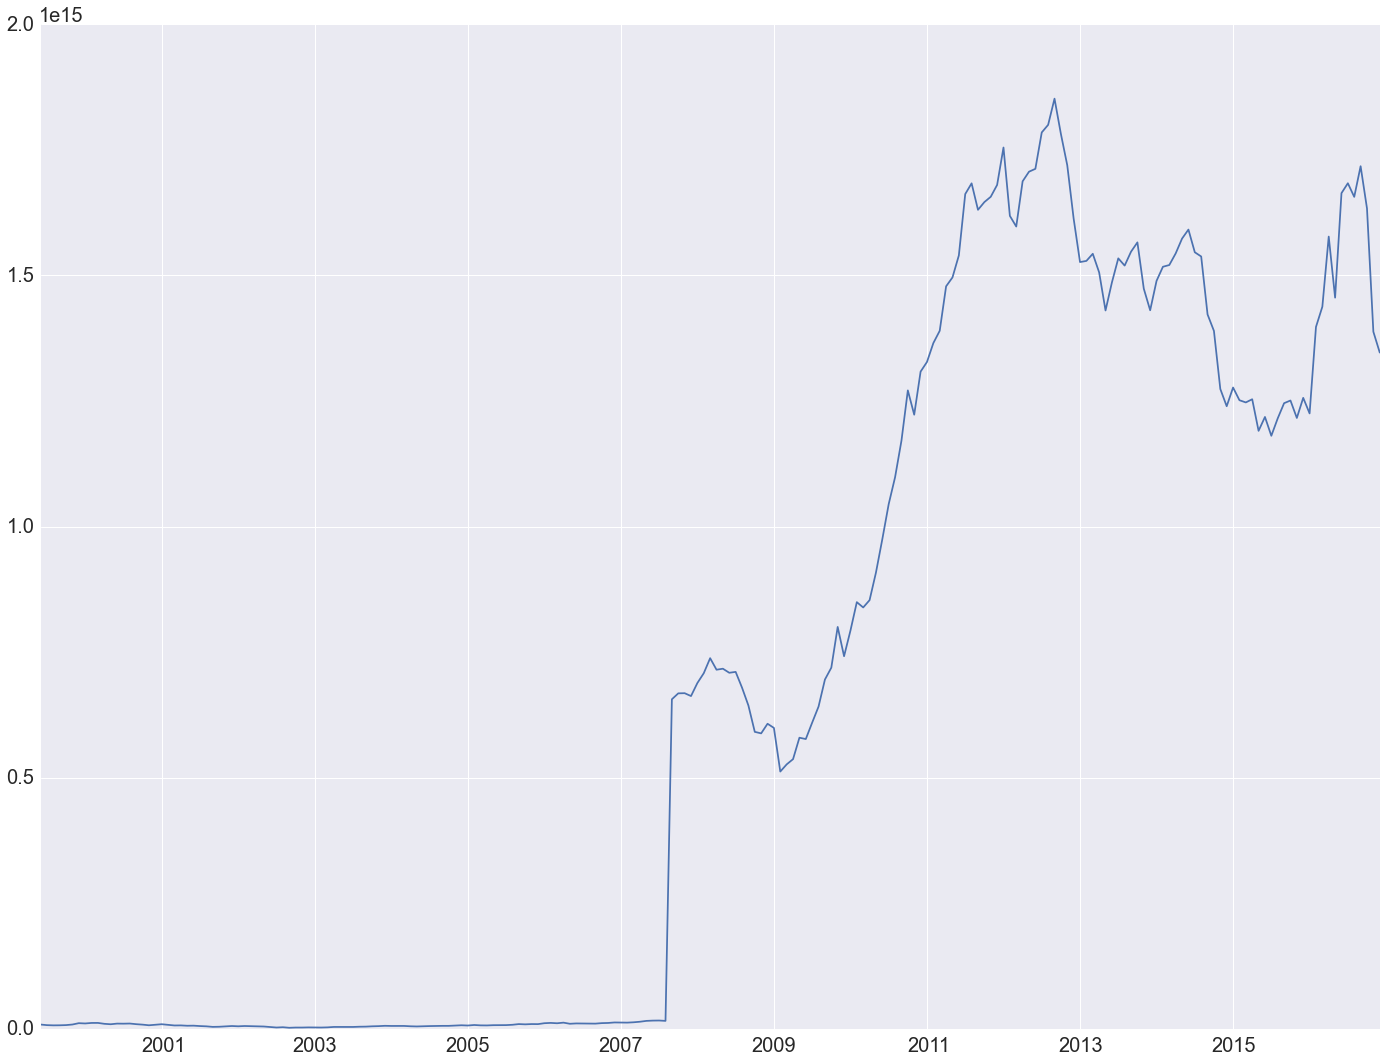

In [6]:
dvol.dropna(how='all').sum(axis=1).plot()

# Funding Rates

* TED spread

In [7]:
ted=quandl.get('FRED/TEDRATE',token=token).Value

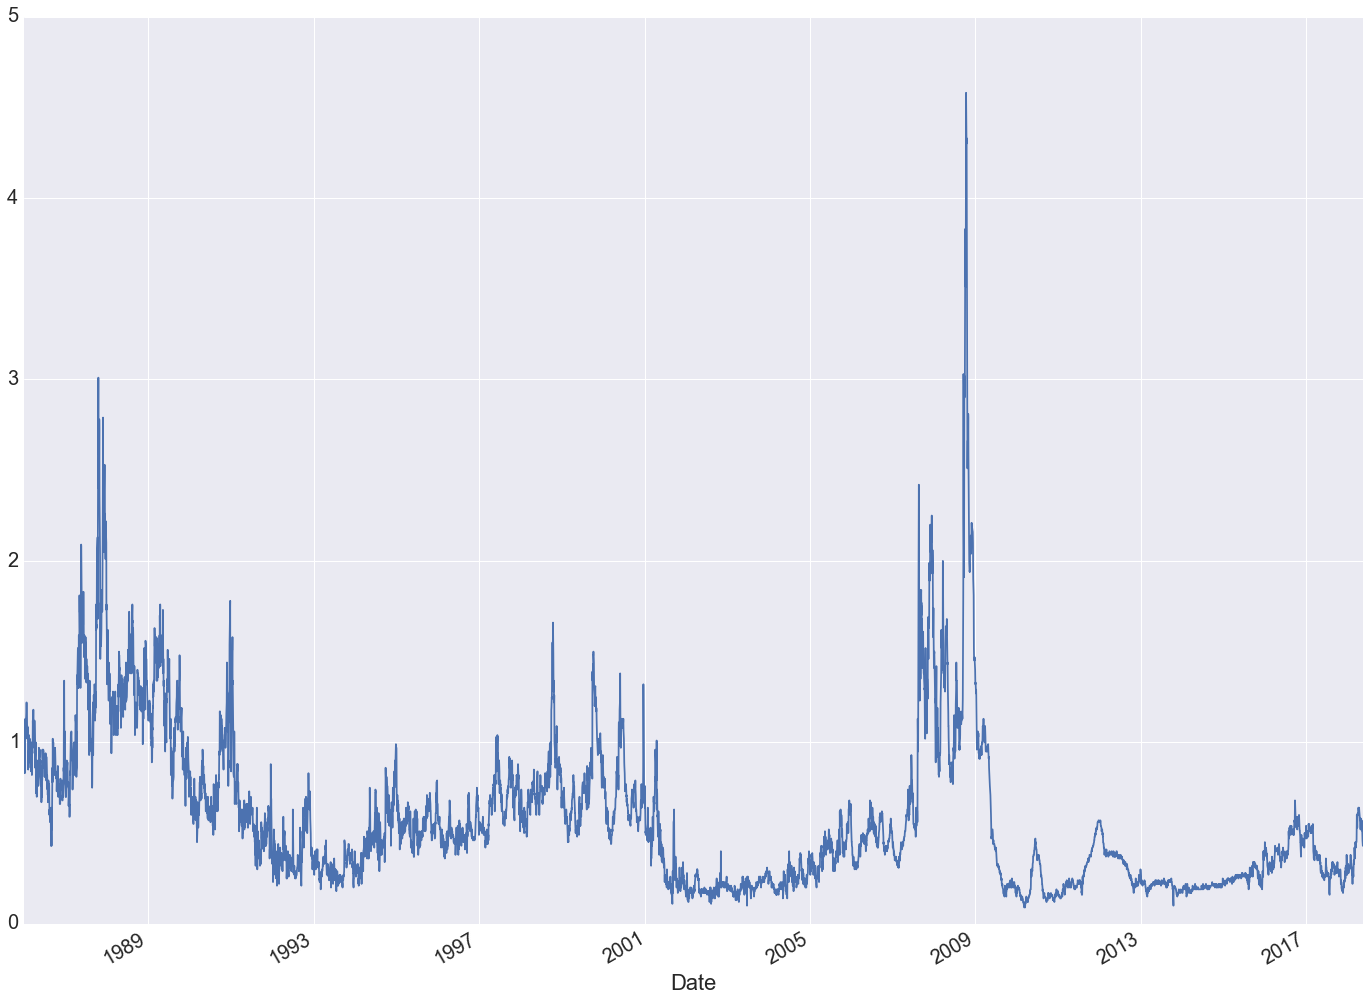

In [8]:
ted.plot()

# Swap versus cash financed

OIS - Tbills

* Missing OIS data

In [9]:
tbill=quandl.get('FRED/DTB3',token=token).Value

# Libor term repo

Overight - Repo rate

* Missing LIBOR O/N rate
* Ticker is FRED/USDONTDIS6N (or something similar)

In [10]:
libor=quandl.get('FRED/USDONTD156N',token=token).VALUE
repo=pd.read_csv('repo.csv',index_col=0,parse_dates=True)
# This needs to get replaced with 
libor_term_repo=(repo.TreasuryRepo-libor).dropna()

# On the run versus off the run 

In [11]:
us10y_zero=quandl.get('FED/SVENY',token=token).SVENY10.resample(rule='d',how='last').dropna()
yield10=quandl.get('USTREASURY/YIELD',token=token)['10 YR'].resample(rule='d',how='last').dropna()
on_off=(us10y_zero-yield10).dropna()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


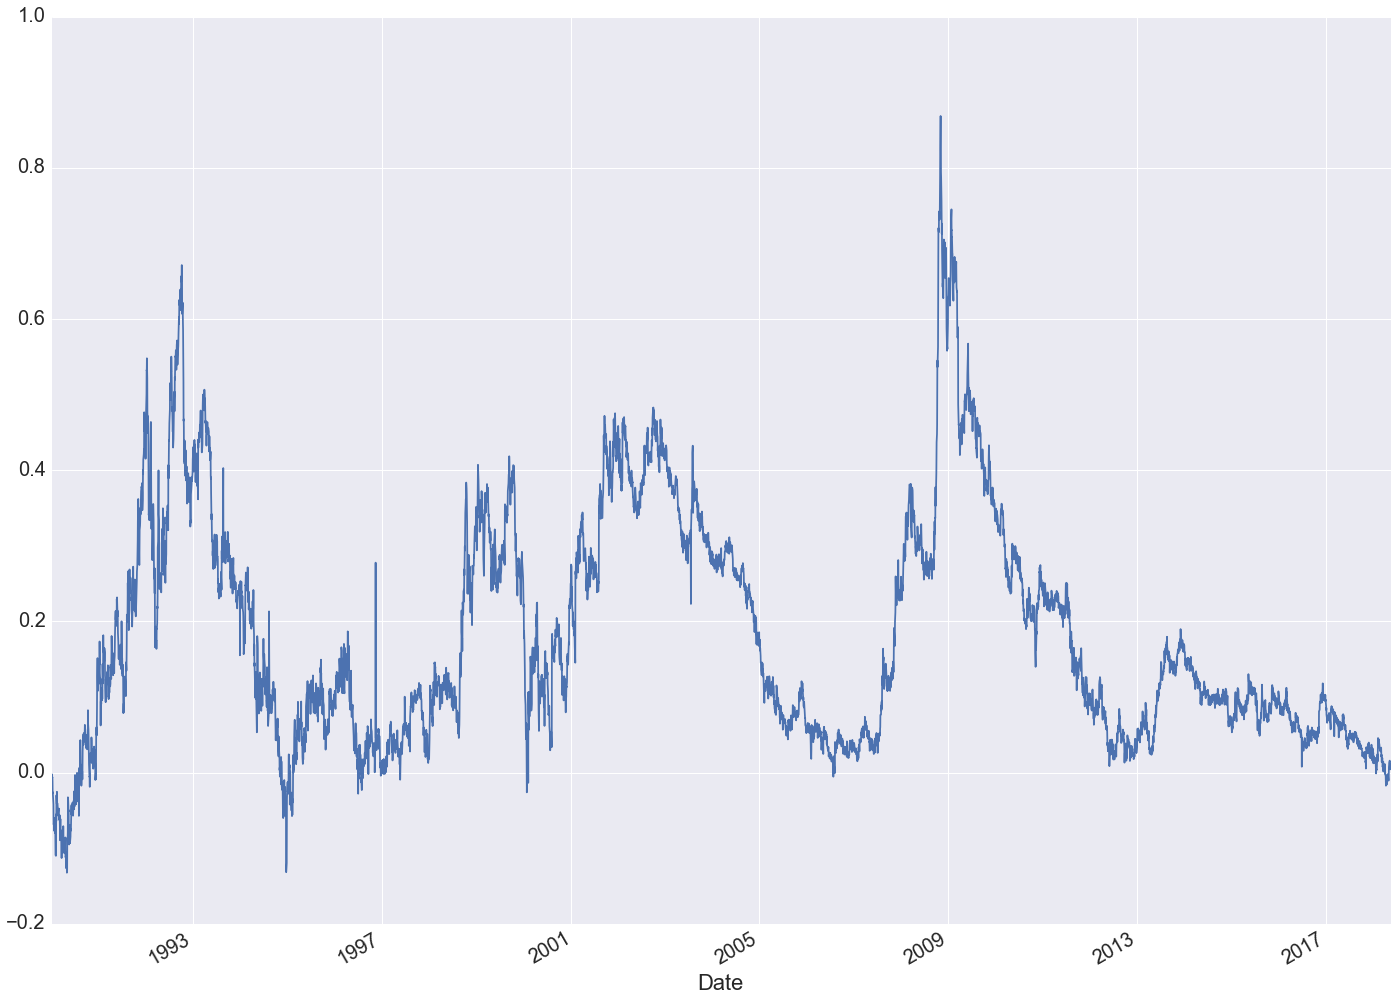

In [12]:
on_off.plot()

# Pastor and Stambagh  (2003)

https://faculty.chicagobooth.edu/lubos.pastor/research/liq_data_1962_2016.txt

In [13]:
PS=pd.read_csv('PS.csv',index_col=0,parse_dates=True).resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


# Getting everything ready for regressions

In [14]:
funding_liquidity = pd.DataFrame()
market_liquidity = pd.DataFrame()
funding_liquidity['TED Spread']=ted.resample(rule='m',how='last')/100.
funding_liquidity['LIBOR term repo']=libor_term_repo.resample(rule='m',how='last')/100.


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.


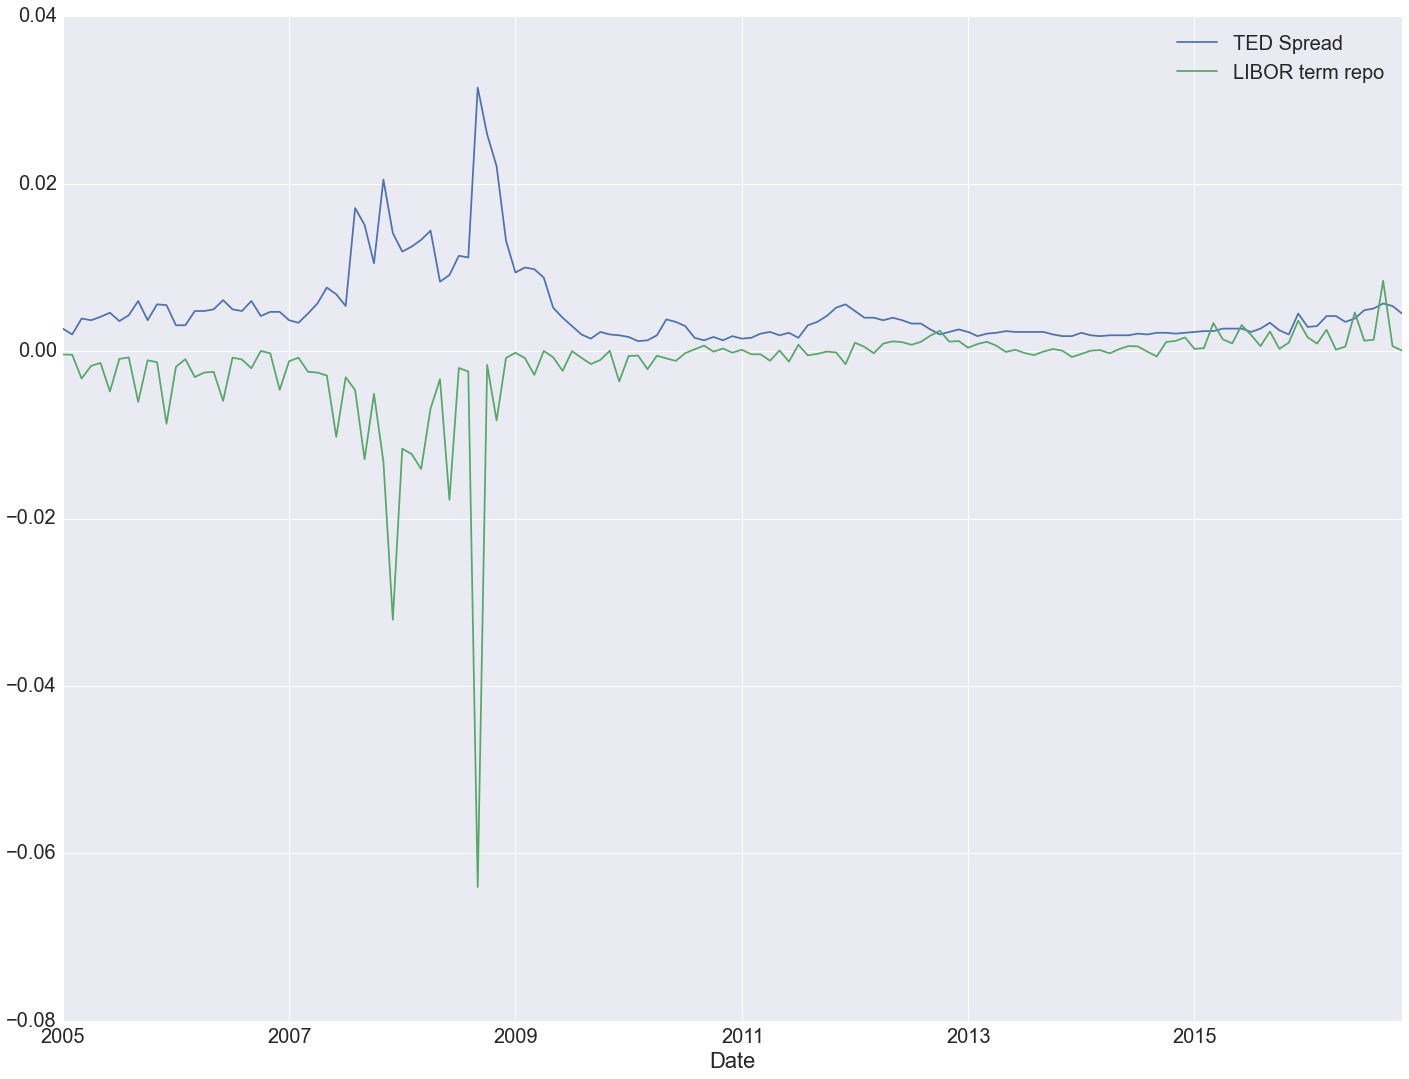

In [15]:
funding_liquidity.dropna().plot()

In [16]:
market_liquidity = pd.DataFrame()
market_liquidity['PS']=PS['Innovations in aggregate liquidity'].resample(rule='m',how='last')
market_liquidity['On versus off the run Treasuries']=on_off.resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  This is separate from the ipykernel package so we can avoid doing imports until


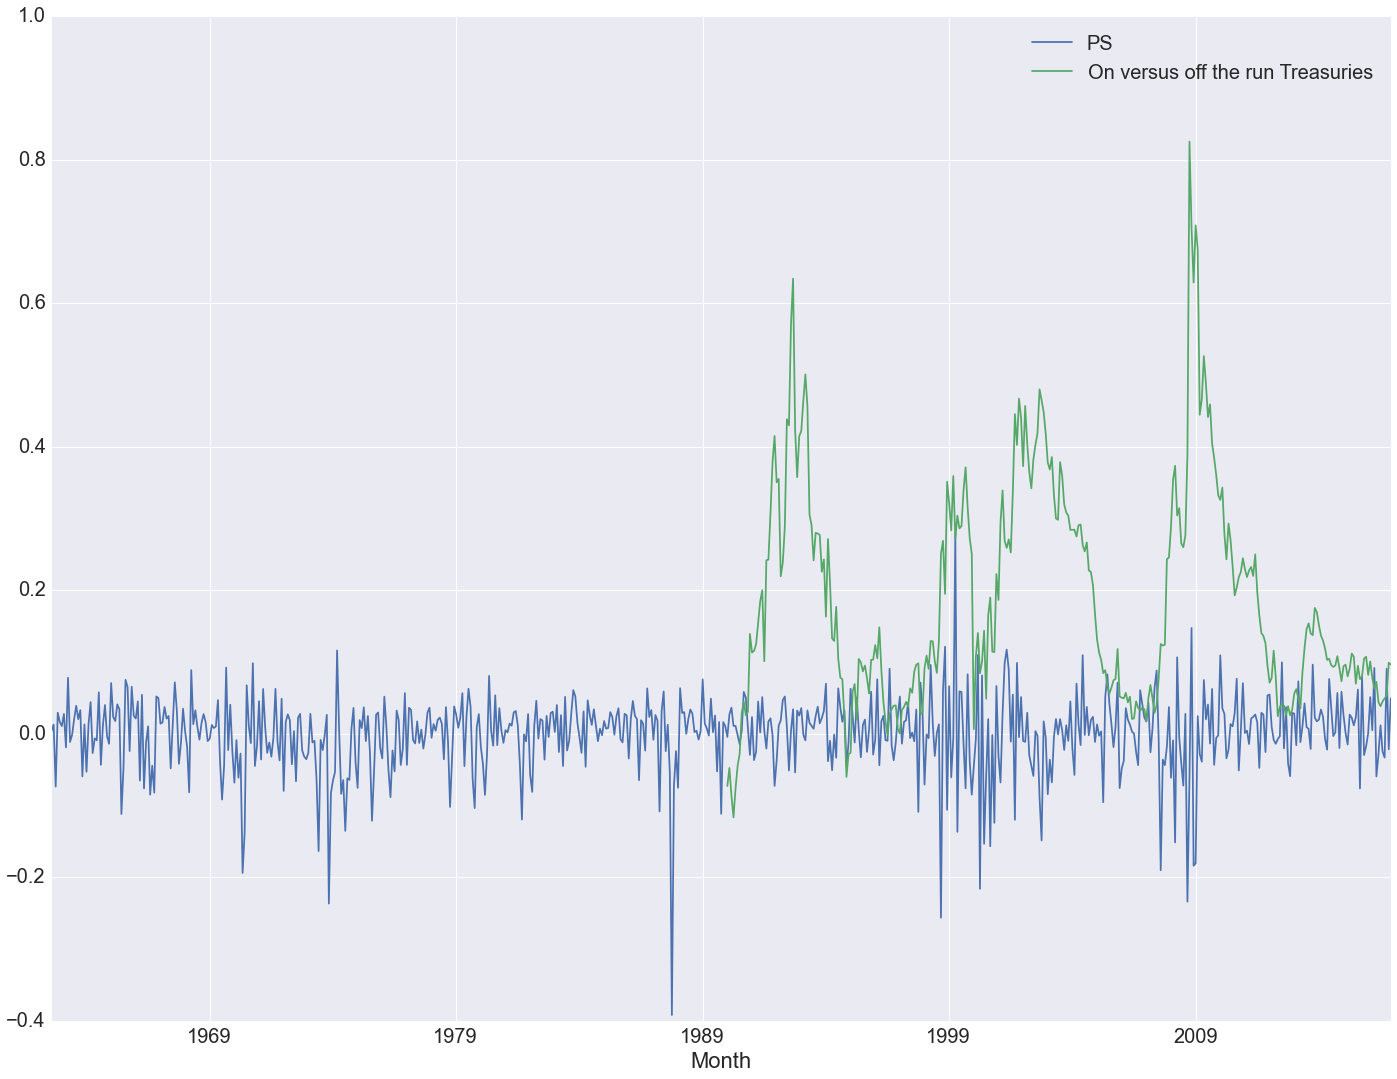

In [17]:
market_liquidity.plot()

# Determinents of Liquidity

In [18]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:42: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:46: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:49: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

In [19]:
#data=calc_zscore_ew(amihud.dropna(how='all')).dropna(how='all')
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')

tsmom_model.py:273: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
tsmom_model.py:273: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [20]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [21]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [23]:
sector_PC.keys()

['Agriculturals',
 'Currencies',
 'Energies',
 'Equities',
 'Metals',
 'Fixed Income']

In [24]:
sector_factor=pd.DataFrame()
for s in ['Agriculturals',
         'Energies',
         'Equities',
         'Metals',
         'Fixed Income']:
    sector_factor[s]=sector_PC[s].mean(axis=1)

# Market Liqudity for Amihud common factors across asset classes




In [25]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind=sector_factor[s].index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

In [26]:
results_df.T

,0,1,2,3,4
PS,1.84124,0.380215,1.725559,-2.473121,-3.146556
PSTstats,1.56679,0.542666,0.966717,-1.555488,-2.881395
On versus off the run Treasuries,-2.58829,-1.228051,-1.707866,1.973141,3.147490
On versus off the run TreasuriesTstats,-3.43182,-2.490741,-1.760650,2.381601,9.080347


# Funding Liqudity for Amihud common factors across asset classes

Note, since our repo data doesn't go back as long the we only look at it from 2005 to 2016



In [27]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [28]:
results_df.T.round(2)

,Agriculturals,Energies,Equities,Metals,Fixed Income
PS,1.84,0.38,1.73,-2.47,-3.15
PSTstats,1.57,0.54,0.97,-1.56,-2.88
On versus off the run Treasuries,-2.59,-1.23,-1.71,1.97,3.15
On versus off the run TreasuriesTstats,-3.43,-2.49,-1.76,2.38,9.08
TED Spread,9.16,6.62,67.08,118.42,77.00
TED SpreadTstats,0.57,0.67,4.07,4.71,5.65
LIBOR term repo,2.76,-6.08,-38.55,-52.77,-45.41
LIBOR term repoTstats,0.39,-1.45,-3.60,-4.67,-6.69


In [29]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &  Agriculturals &  Energies &  Equities &  Metals &  Fixed Income \\
\midrule
PS                                     &           1.84 &      0.38 &      1.73 &   -2.47 &         -3.15 \\
PSTstats                               &           1.57 &      0.54 &      0.97 &   -1.56 &         -2.88 \\
On versus off the run Treasuries       &          -2.59 &     -1.23 &     -1.71 &    1.97 &          3.15 \\
On versus off the run TreasuriesTstats &          -3.43 &     -2.49 &     -1.76 &    2.38 &          9.08 \\
TED Spread                             &           9.16 &      6.62 &     67.08 &  118.42 &         77.00 \\
TED SpreadTstats                       &           0.57 &      0.67 &      4.07 &    4.71 &          5.65 \\
LIBOR term repo                        &           2.76 &     -6.08 &    -38.55 &  -52.77 &        -45.41 \\
LIBOR term repoTstats                  &           0.39 &     -1.45 &     -3.60 &   -4.67 &         -6.69 \\
\bottomrule
\

# Run for unanticipated shocks from residuals from AR(2)

In [30]:
resid={}
for sector in sector_PC.keys():
    first_com=sector_PC[sector][0]
    temp=first_com.shift(2).dropna()
    #temp=first_com.diff().dropna()
    res=sm.OLS(temp,first_com.loc[temp.index]).fit()
    resid[sector]=res.resid
resid=pd.DataFrame(resid)

In [31]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind=resid[s].index
        # Please make the fit robust 
        res=sm.OLS(resid[s],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

In [32]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


ValueError: Length mismatch: Expected axis has 6 elements, new values have 5 elements

In [ ]:
results_df.T.round(2)

In [33]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &      0 &      1 &      2 &      3 &      4 &      5 \\
\midrule
PS                                     &   2.41 &  -0.99 &  -1.20 &  -0.01 &   0.56 &  -0.73 \\
PSTstats                               &   1.14 &  -0.22 &  -0.86 &  -0.00 &   0.23 &  -0.25 \\
On versus off the run Treasuries       &  -0.57 &  -3.17 &  -0.03 &  -4.17 &   1.56 &   2.73 \\
On versus off the run TreasuriesTstats &  -0.46 &  -1.70 &  -0.06 &  -2.32 &   1.40 &   2.39 \\
TED Spread                             & -68.53 &  53.13 &  16.21 &  29.99 & -32.83 & -30.44 \\
TED SpreadTstats                       &  -1.45 &   0.66 &   1.05 &   0.66 &  -0.74 &  -0.57 \\
LIBOR term repo                        &  59.16 & -86.43 &  -1.58 & -26.87 &  51.59 &  52.55 \\
LIBOR term repoTstats                  &   3.52 &  -4.11 &  -0.22 &  -3.70 &   5.98 &   2.84 \\
\bottomrule
\end{tabular}



# FHT method

In [49]:
FHT=calculate_FHT(cleansed)

In [50]:
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')

In [51]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [52]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [53]:
sector_factor=pd.DataFrame()
for s in sector_PC.keys():
    sector_factor[s]=sector_PC[s].mean(axis=1)

# Market liquidity
TODO: Make errors robus

In [54]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=market_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [55]:
results_df.T.round(2)

,0,1,2,3,4,5
PS,2.43,2.10,-2.73,5.52,2.42,3.17
PSTstats,2.23,1.89,-3.48,2.95,1.95,2.14
On versus off the run Treasuries,-1.83,-2.00,1.11,-2.73,-1.44,-2.47
On versus off the run TreasuriesTstats,-6.19,-4.74,2.70,-2.49,-2.57,-4.64


In [56]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [57]:
results_df.T.round(2)

,Agriculturals,Currencies,Energies,Equities,Metals,Fixed Income
PS,2.43,2.10,-2.73,5.52,2.42,3.17
PSTstats,2.23,1.89,-3.48,2.95,1.95,2.14
On versus off the run Treasuries,-1.83,-2.00,1.11,-2.73,-1.44,-2.47
On versus off the run TreasuriesTstats,-6.19,-4.74,2.70,-2.49,-2.57,-4.64
TED Spread,-55.20,-66.88,54.55,-216.18,-104.17,-104.68
TED SpreadTstats,-3.69,-3.34,3.29,-6.03,-4.55,-3.77
LIBOR term repo,36.51,43.64,-20.08,85.32,45.15,72.63
LIBOR term repoTstats,2.75,5.83,-1.31,7.08,3.52,6.13


In [58]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  Agriculturals &  Currencies &  Energies &  Equities &  Metals &  Fixed Income \\
\midrule
PS                                     &           2.43 &        2.10 &     -2.73 &      5.52 &    2.42 &          3.17 \\
PSTstats                               &           2.23 &        1.89 &     -3.48 &      2.95 &    1.95 &          2.14 \\
On versus off the run Treasuries       &          -1.83 &       -2.00 &      1.11 &     -2.73 &   -1.44 &         -2.47 \\
On versus off the run TreasuriesTstats &          -6.19 &       -4.74 &      2.70 &     -2.49 &   -2.57 &         -4.64 \\
TED Spread                             &         -55.20 &      -66.88 &     54.55 &   -216.18 & -104.17 &       -104.68 \\
TED SpreadTstats                       &          -3.69 &       -3.34 &      3.29 &     -6.03 &   -4.55 &         -3.77 \\
LIBOR term repo                        &          36.51 &       43.64 &    -20.08 &     85.32 &   45.15 &         72.63 \\
LIBOR ter

# Run for unanticipated shocks from residuals from AR(2)


In [44]:
resid={}
for sector in sector_PC.keys():
    first_com=sector_PC[sector][0]
    temp=first_com.shift(2).dropna()
    #temp=first_com.diff().dropna()
    res=sm.OLS(temp,first_com.loc[temp.index]).fit()
    resid[sector]=res.resid
resid=pd.DataFrame(resid)

In [45]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=market_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [46]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [47]:
results_df.T.round(2)

,Agriculturals,Currencies,Energies,Equities,Metals,Fixed Income
PS,1.05,-1.24,2.49,4.29,-3.41,2.51
PSTstats,0.49,-0.38,1.25,0.68,-1.32,0.75
On versus off the run Treasuries,-2.67,-3.48,1.68,-6.27,-2.50,-2.08
On versus off the run TreasuriesTstats,-2.51,-2.36,1.64,-2.44,-2.17,-1.46
TED Spread,-101.29,-4.62,32.27,-171.35,-44.94,-78.51
TED SpreadTstats,-1.76,-0.06,0.72,-1.38,-0.72,-1.12
LIBOR term repo,-9.56,-52.48,11.65,7.94,-20.76,-30.24
LIBOR term repoTstats,-0.47,-1.43,0.45,0.17,-0.64,-0.96


In [48]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  Agriculturals &  Currencies &  Energies &  Equities &  Metals &  Fixed Income \\
\midrule
PS                                     &           1.05 &       -1.24 &      2.49 &      4.29 &   -3.41 &          2.51 \\
PSTstats                               &           0.49 &       -0.38 &      1.25 &      0.68 &   -1.32 &          0.75 \\
On versus off the run Treasuries       &          -2.67 &       -3.48 &      1.68 &     -6.27 &   -2.50 &         -2.08 \\
On versus off the run TreasuriesTstats &          -2.51 &       -2.36 &      1.64 &     -2.44 &   -2.17 &         -1.46 \\
TED Spread                             &        -101.29 &       -4.62 &     32.27 &   -171.35 &  -44.94 &        -78.51 \\
TED SpreadTstats                       &          -1.76 &       -0.06 &      0.72 &     -1.38 &   -0.72 &         -1.12 \\
LIBOR term repo                        &          -9.56 &      -52.48 &     11.65 &      7.94 &  -20.76 &        -30.24 \\
LIBOR ter